# In Google Colabo, go to  **"Change runtime type"** and choose **"T4 GPU"** !!

In [1]:
# @title Loading data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/lorenz3dim_segments.npy'

import pandas as pd
import numpy as np

data = np.load(file_path)
data = np.array(data)

#standardization

mean_value = np.mean(data)
std_dev    = np.std(data)
data       = (data - mean_value) / std_dev

Mounted at /content/drive


In [2]:
# @title Loading optuna and libraries
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import networkx as nx
import csv
import datetime

!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 30.4 MB/s eta 0:00:00


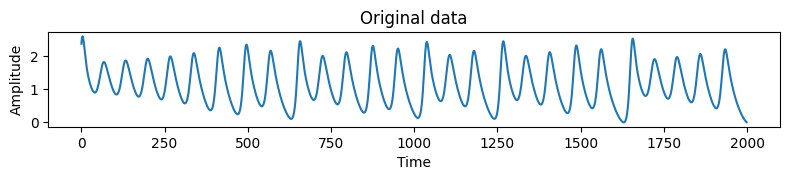

Data shape: (525, 2000, 3)


In [3]:
# @title Visualization

plt.figure(figsize=(8, 3))
plt.subplot(2, 1, 1)
plt.plot(data[0,:,2])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

print('Data shape:',data.shape)

In [4]:
# @title Definition of Reservoir computing (without ``Class" setting!!)

####################
#input weight matrix
####################

def input_matrix(N_x,seed_value,input_scale,dim):

# Separate integer and decimal portions
    seed_int_low  = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction      = seed_value - seed_int_low

# Random number generation for integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

# Linear interpolation allows random seed values to correspond continuously to the matrix
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix

##############################
# Recurrent weight matrix
##############################

#Specify non-zero positions
def generate_random_binary_matrix(N_x, N_y, density, seed_value_binary):

    num_ones = int(N_x*N_y * density)
    matrix   = np.zeros(N_x*N_y, dtype=int)
    np.random.seed(seed_value_binary)
    ones_indices = np.random.choice(N_x*N_y, num_ones, replace=False)
    matrix[ones_indices] = 1

    return matrix.reshape((N_x, N_y))


def recurrent_matrix(N_x, density, rho,seed_value):

# Separate random seed value into integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

        random_binary_matrix_low   = generate_random_binary_matrix(N_x, N_x, density, seed_int_low)
        random_binary_matrix_high  = generate_random_binary_matrix(N_x, N_x, density, seed_int_high)
        interpolated_binary_matrix = \
         (1 - fraction) * random_binary_matrix_low + fraction * random_binary_matrix_high


# Separate integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

# Generate nonzero elements as random numbers following a uniform distribution
        rec_scale = 1.0

# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# Linear interpolation allows random seed values and matrices to correspond continuously
        interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

        W = interpolated_binary_matrix * interpolated_matrix

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W


#############################
# reservoir state vector
#############################

def Reservoir_batch(x_in, x, W, alpha, bias_scale):
    M, N_x = x.shape
    Wbias = np.ones((M, N_x)) * bias_scale
    x = (1.0 - alpha) * x + alpha * np.tanh(x @ W.T + Wbias + x_in)
    return x

############################
#Ridge Regression and  Output Weight Matrix
############################

# We employ the excellent Ohkubo-Inubushi method here
#See Scientific Reports volume 14, Article number: 30918 (2024)

def quadratic_expand(x):
    x = np.asarray(x)
    if x.ndim == 1:
        x = x.reshape(1, -1)   # 1 sample case
    n_samples, n_features = x.shape

    # Obtain indices of the upper triangle (i<=j)
    i, j = np.triu_indices(n_features)

    #Generate quadratic terms for all samples at once -> shape (n_samples, n_pairs)
    s = x[:, i] * x[:, j]

    # Join along the column axis (axis=1) -> shape (n_samples, n_features + n_pairs)
    x_quad = np.concatenate([x, s], axis=1)
    return x_quad


def Ridge_batch(d, x, X_XT, D_XT):
    """
    x: (M, N_x)
    d: (M, N_y)
    X_XT: (N_x, N_x)
    D_XT: (N_y, N_x)
    """

    x_quad = quadratic_expand(x)

    X_XT += x_quad.T @ x_quad  # (N_x, M) @ (M, N_x) -> (N_x, N_x)
    D_XT += d.T @ x_quad       # (N_y, M) @ (M, N_x) -> (N_y, N_x)
    return X_XT, D_XT


def get_Wout_opt(X_XT,D_XT,N_x,beta):

        Wout_opt = np.linalg.solve((X_XT + beta * np.identity(X_XT.shape[0])).T, D_XT.T)
        Wout_opt=Wout_opt.T

        return Wout_opt

###################
#Definition of batch learning (convexity)
###################

def train(train_U,train_D, x, T_train,Win,W,N_x,dim,alpha,spinup_len,bias_scale):

    # Calculate the size of the expanded state vector
    expanded_size = N_x + int(N_x * (N_x + 1) / 2)

    X_XT          = np.zeros((expanded_size, expanded_size))
    D_XT          = np.zeros((dim, expanded_size))
    x_special_vec = np.zeros((train_U.shape[0],N_x))
    x             = np.zeros((train_U.shape[0], N_x))  # (M, N_x)

    for n in range(T_train):
        # Input (batched)
        u = train_U[:, n, :]                   # (M, input_dim)

        # Reservoir induction (batch)
        x_in = u @ Win.T                       # (M, N_x)
        x = Reservoir_batch(x_in, x, W, alpha, bias_scale)

        # teacher data
        d = train_D[:, n, :]                   # (M, output_dim)

        if n > spinup_len:                    # discard the first part
            X_XT, D_XT = Ridge_batch(d, x, X_XT, D_XT)

    # the last Reservoir vectors
    x_special_vec = x  # (M, N_x)

    return X_XT, D_XT, x_special_vec

########################
#induction formula for creating estimated data
########################

def run_batch(test_U, x, Win, W, Wout, alpha, T_test, bias_scale):
    """
    test_U : (M, input_dim)
    x      : (M, N_x): reservoir state
    Win    : (N_x, input_dim)
    W      : (N_x, N_x)
    Wout   : (output_dim, N_x)
    """

    y = test_U
    Y_pred = []

    for n in range(T_test):
        # Reservoir induction（batched）
        x_in = y @ Win.T
        x = Reservoir_batch(x_in, x, W, alpha, bias_scale)

        # Output
        x_quad = quadratic_expand(x)
        y_pred = x_quad @ Wout.T
        Y_pred.append(y_pred)
        y = y_pred

    # Prediction to NumPy array
    Y_pred = np.stack(Y_pred, axis=1)  # (M, T_test, output_dim)

    return Y_pred

In [5]:
# @title Definition of implementation of train and test


def impl_train_test(T_train,train_set,select_set,dim,N_x,seed_value,input_scale,density, \
                    rho,alpha,spinup_len,bias_scale,beta,T_test):



#Initialization of estimated data

    test_Y           = np.zeros((select_set.shape[0],T_test,dim))
    test_D           = np.zeros((select_set.shape[0],T_test,dim))

#Fix input and recurrent weight matrices

    Win= input_matrix(N_x,seed_value,input_scale,dim)
    W = recurrent_matrix(N_x, density, rho,seed_value)

##########################################

# Initialization of training data

    train_U = np.zeros((train_set.shape[0],T_train,dim), dtype=float)
    train_D = np.zeros((train_set.shape[0],T_train,dim), dtype=float)

#Input/output of training data

    train_U = train_set[:,:T_train,:]
    train_D = train_set[:,1:T_train+1,:]

##The last time data of the training data output must overlap with the test data,
##since non-increment online learning!

#Ridge

    X_XT, D_XT,_ = train(train_U,train_D,np.zeros(N_x),T_train, \
                                  Win, W, N_x, dim, alpha,spinup_len,bias_scale)

# Generate regression weight matrix

    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

#######################
# Model selection phase

# Initialization of training data


    train_U = np.zeros((select_set.shape[0],spinup_len,dim), dtype=float)
    train_D = np.zeros((select_set.shape[0],spinup_len,dim), dtype=float)

#Input/output of training data

    train_U[:,:,:] = select_set[:,:spinup_len,:]
    train_D[:,:,:] = select_set[:,1:spinup_len+1,:]

##The last time data of the training data output must overlap with the test data!

#Ridge

    _, _,x_special_vec = train(train_U,train_D,np.zeros(N_x),spinup_len, Win, W, N_x, dim, alpha,spinup_len,bias_scale)


##############################
#test in model selection phase

#Generate estimated data

    test_Y[:,:,:] = run_batch(select_set[:,spinup_len,:],x_special_vec[:,:], \
                                      Win,W,Wout,alpha,T_test,bias_scale)
    test_D[:,:,:] = select_set[:,spinup_len+1:spinup_len+T_test+1,:]

    #average error over all time steps
    return np.abs(test_Y[:,:T_test-1,:]-test_D[:,:T_test-1,:]), test_Y, test_D


In [6]:
# @title Setting of Optuna study

# --------------------
# Study 1 (no save = memory)
# --------------------
memory_storage = "sqlite:///:memory:"
study_without_save = optuna.create_study(
    study_name="Parallel_Reservoir_MemoryOnly",
    storage=memory_storage,
    direction="minimize",
    load_if_exists=False
)

# --------------------
# Study 2 (with save = SQLite)
# --------------------
storage = "sqlite:////content/drive/My Drive/Colab Notebooks/reservoir_quadoutput_trials.db"
study_with_save = optuna.create_study(
    study_name="Parallel_Reservoir_QuadOutput",
    storage=storage,
    direction="minimize",
    load_if_exists=True
)


[I 2025-11-20 13:00:04,037] A new study created in RDB with name: Parallel_Reservoir_MemoryOnly
[I 2025-11-20 13:00:04,922] Using an existing study with name 'Parallel_Reservoir_QuadOutput' instead of creating a new one.


In [7]:
# @title Hyperparameters

T_train                = data.shape[1]-1 # Training period
T_test                 = 1000            # Forecast period (in the model selection phase)
T_test_general_perform = 1000            # Forecast period for generalizaiton performance (model evaluation phase)

spinup_len  = 100    # Number of steps not learned at the beginning (not important)

dim = data.shape[2]

#####################################################
#Hyperparameters: Bayesian optimization for Reservoir

Node      = 60    # Reservoir Node (for Inubushi-Ookubo method)
n_trials  = 20    # Number of times to test with optuna (generate MAE for this number of times)

study = study_with_save # choose ``study_without_save" or ``study_with_save""

In [8]:
evalu_ratio  = 0.9
select_ratio = 0.7

In [9]:
train_set  = data[:int(data.shape[0]*evalu_ratio*select_ratio)+1,:]
select_set = data[int(data.shape[0]*evalu_ratio*select_ratio)+1:int(data.shape[0]*evalu_ratio)+1,:]
test_set   = data[int(data.shape[0]*evalu_ratio)+1:,:]

print("train_set shape",train_set.shape)
print("model_selection_set shape",select_set.shape)
print("general_perform_set shape",test_set.shape)

train_set shape (331, 2000, 3)
model_selection_set shape (142, 2000, 3)
general_perform_set shape (52, 2000, 3)


In [10]:
# @title Implementation of Bayesian optimization of Reservoir

%%time

def objective(trial):

    N_x         = trial.suggest_int("N_x", Node, Node)                #fixed here
    beta        = trial.suggest_float("beta", 0.0001, 0.0001)
    density     = trial.suggest_float("density", 0.01, 1)
    input_scale = trial.suggest_float("input_scale", 0, 1.5)
    rho         = trial.suggest_float("rho", 0, 1.5)
    alpha       = trial.suggest_float("alpha", 0, 1)
    seed_value  = trial.suggest_float("seed_value", 0, 100)
    bias_scale  = trial.suggest_float("bias_scale", -1.5, 1.5)

    #Test start time (model selection phase)

    #Implementation of train-test

    mae,_,_ = impl_train_test(T_train,train_set,select_set,dim,N_x,seed_value,input_scale,density, \
                    rho,alpha,spinup_len,bias_scale,beta,T_test)

    return np.mean(mae)

######################
# Perform optimization

study.optimize(objective, n_trials)

# Display of optimization results
print("Best trial:")
trial = study.best_trial
print(f"  'params': {trial.params},")
print(f"  'value': {trial.value},")

[I 2025-11-20 13:00:50,102] Trial 75 finished with value: 0.020770166930187836 and parameters: {'N_x': 60, 'beta': 0.0001, 'density': 0.11683681782683955, 'input_scale': 1.437032663588173, 'rho': 0.5418779502672801, 'alpha': 0.137694186758274, 'seed_value': 11.603899839186857, 'bias_scale': 0.8898275191633566}. Best is trial 69 with value: 0.011744057257164854.
[I 2025-11-20 13:01:34,759] Trial 76 finished with value: 0.08422346368203648 and parameters: {'N_x': 60, 'beta': 0.0001, 'density': 0.06734108766160277, 'input_scale': 1.449146726851676, 'rho': 0.6515589685394122, 'alpha': 0.08179035287662162, 'seed_value': 5.344388270826874, 'bias_scale': 1.1028579353376595}. Best is trial 69 with value: 0.011744057257164854.
[I 2025-11-20 13:02:20,172] Trial 77 finished with value: 0.024704596487468304 and parameters: {'N_x': 60, 'beta': 0.0001, 'density': 0.23473640912426355, 'input_scale': 1.287979513729339, 'rho': 0.5767559098060585, 'alpha': 0.15130168342872216, 'seed_value': 2.0578338655

Best trial:
  'params': {'N_x': 60, 'beta': 0.0001, 'density': 0.05800232835428845, 'input_scale': 1.4874078494402445, 'rho': 0.6335178390380041, 'alpha': 0.14066303735801716, 'seed_value': 2.932245793578712, 'bias_scale': 1.4098646449264032},
  'value': 0.011744057257164854,
CPU times: user 2h 40min 44s, sys: 3.53 s, total: 2h 40min 47s
Wall time: 15min 12s


In [11]:
# @title Best hyperparameters

best_params = study.best_params

N_x          = best_params["N_x"]
beta         = best_params["beta"]
density      = best_params["density"]
input_scale  = best_params["input_scale"]
rho          = best_params["rho"]
alpha        = best_params["alpha"]
seed_value   = best_params["seed_value"]
bias_scale   = best_params["bias_scale"]

print(f"N_x= {N_x}")
print(f"beta= {beta}")
print(f"density= {density}")
print(f"input_scale= {input_scale}")
print(f"rho= {rho}")
print(f"alpha= {alpha}")
print(f"seed_value= {seed_value}")
print(f"bias_scale= {bias_scale}")


N_x= 60
beta= 0.0001
density= 0.05800232835428845
input_scale= 1.4874078494402445
rho= 0.6335178390380041
alpha= 0.14066303735801716
seed_value= 2.932245793578712
bias_scale= 1.4098646449264032


In [12]:
train_set  = data[:int(data.shape[0]*evalu_ratio)+1,:]
test_set   = data[int(data.shape[0]*evalu_ratio)+1:,:]

print("train_set shape",train_set.shape)
print("general_perform_set shape",test_set.shape)

train_set shape (473, 2000, 3)
general_perform_set shape (52, 2000, 3)


In [13]:
# @title Training in Model Evaluation phease

%%time

mae,test_Y,test_D = impl_train_test(T_train,train_set,test_set,dim,N_x,seed_value,input_scale,density, \
                    rho,alpha,spinup_len,bias_scale,beta,T_test_general_perform)

mae_mean = np.mean(mae)

CPU times: user 9min 28s, sys: 169 ms, total: 9min 28s
Wall time: 52.6 s


MAE mean: 0.013919125482871168
forecast period for general-perform: 1000


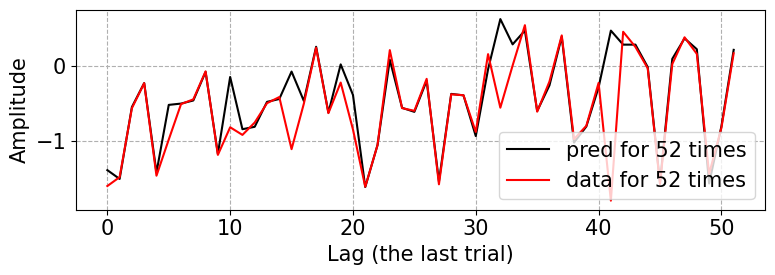

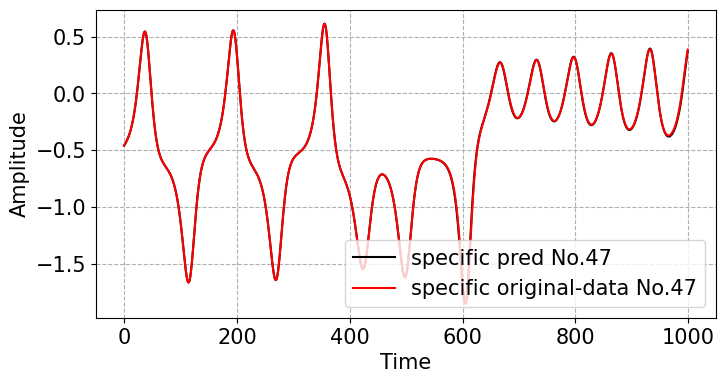

CPU times: user 245 ms, sys: 2 ms, total: 247 ms
Wall time: 246 ms


In [16]:
# @title Implementation of Model Evaluation

%%time

#print("MAE:", mae)
print("MAE mean:", mae_mean)
print("forecast period for general-perform:", T_test_general_perform)

fig = plt.figure(figsize=(8,3), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag (the last trial)")
plt.ylabel("Amplitude")
plt.plot(test_Y[:,T_test_general_perform-1,0], color="black", label=f"pred for {test_Y.shape[0]} times")
plt.plot(test_D[:,T_test_general_perform-1,0], color = "red",label=f"data for {test_D.shape[0]} times")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

fix_test_num = 47

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(test_Y[fix_test_num,:,0], color = "black",label=f"specific pred No.{fix_test_num}")
plt.plot(test_D[fix_test_num,:,0], color = "red",label=f"specific original-data No.{fix_test_num}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()

In [15]:
# @title Visualization of past trials

# past_study = optuna.load_study(study_name="Parallel_Reservoir_QuadOutput", storage=storage)
# df = past_study.trials_dataframe()
# print(df)